In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype('float32') / 255
    obs[obs > 0] = 1
    return obs

In [4]:
env = gym.make("Breakout-v0")
init = env.reset()

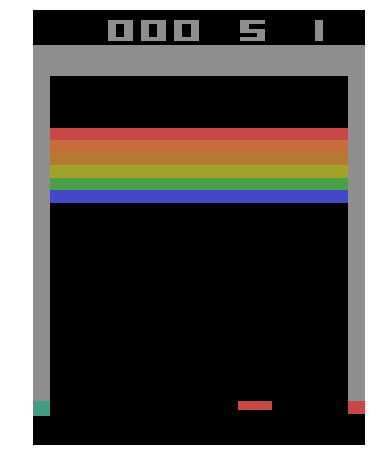

In [5]:
plot_state(init)

In [6]:
I = process_obs(init)

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [7]:
I.shape

(84, 84, 1)

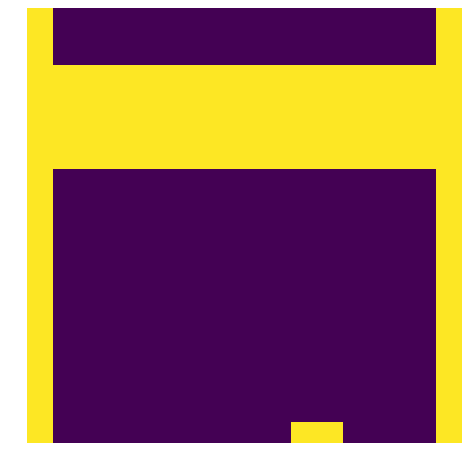

In [8]:
plot_state(I.reshape(84,84))

In [9]:
I.shape

(84, 84, 1)

In [10]:
env.action_space

Discrete(4)

In [11]:
env.observation_space.shape

(210, 160, 3)

In [12]:
inp = Input(shape=(84,84,1))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,1))(inp)
x = Conv2D(32, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.1, patience=2)]
model.compile(loss='mean_squared_error', optimizer='RMSProp', metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        1040      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2655232   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
Total para

In [41]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation = process_obs(observation)


episodes = 10000
epsilon = 0.5
gamma = 0.9
done = False

history = {}


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    history = {"input":[], "reward":[], "action": [], "Q":[]}
    sum = 0
    frame = 0
    game = True
    while game: 
        
        if (frame == 0) or (frame % 4 == 0):
            rand = np.random.uniform(0,1)
            if  rand < epsilon:
                action = env.action_space.sample()
            else:
                observation = np.expand_dims(observation,0)
                action = np.argmax(model.predict(observation))
        else:
            pass
        
        
        observation, reward, done, info = env.step(action)
        observation = process_obs(observation)
        
        history["input"].append(observation)
        history["action"].append(action)
        history["reward"].append(reward)
        sum += reward

        
        #time.sleep(0.001)
        #env.render()
        frame += 1
        if done:
        
            Q = []
            frame = 0
            for j,k in enumerate(history["reward"][::-1]):
                if j == 0:
                    val = np.array([[0, 0, 0, 0]])
                    val[0,history["action"][-1]] = k
                    Q.append(val)
                else:
                    val = np.array([[0, 0, 0, 0]])
                    val[0,history["action"][-1-j]] = k + gamma*Q[-1][0][history["action"][-j]]
                    Q.append(val)
            
            Q = np.array(Q[::-1])
            Q = Q.reshape(Q.shape[0],Q.shape[2])


            history["Q"] = Q 
            
            if sum < 4:
                observation = env.reset()
                observation = process_obs(observation)
                game = False
            else:
                print("Training the model...")
                
                history["input"] = np.array(history["input"])
                print(history["input"].shape)
                model.fit(history["input"], history["Q"], epochs = 4, batch_size=100, callbacks=callbacks_list)
                print("Total game score was: {}\n".format(sum))
            
                observation = env.reset()
                observation = process_obs(observation)
                #epsilon -= 0.01
                game = False
                             
        else:
            pass
            
         

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Welcome to AI Breakout!
Starting Game 1 of 10000...

Welcome to AI Breakout!
Starting Game 2 of 10000...

Welcome to AI Breakout!
Starting Game 3 of 10000...

Welcome to AI Breakout!
Starting Game 4 of 10000...

Training the model...
(446, 84, 84, 1)
Epoch 1/4
446/446 [==============================] - 1s 1ms/step - loss: 0.0197 - mean_absolute_error: 0.0231
Epoch 2/4
446/446 [==============================] - 1s 1ms/step - loss: 0.0190 - mean_absolute_error: 0.0190
Epoch 3/4
446/446 [==============================] - 1s 1ms/step - loss: 0.0190 - mean_absolute_error: 0.0157
Epoch 4/4
446/446 [==============================] - 1s 1ms/step - loss: 0.0190 - mean_absolute_error: 0.0161
Total game score was: 8.0

Welcome to AI Breakout!
Starting Game 5 of 10000...

Welcome to AI Breakout!
Starting Game 6 of 10000...

Welcome to AI Breakout!
Starting Game 7 of 10000...

Welcome to AI Breakout!
Starting Game 8 of 10000...

Welcome to AI Breakout!
Starting Game 9 of 10000...

Training the mode

KeyboardInterrupt: 

In [32]:
observation.shape

(84, 84, 1)

In [33]:
24 % 4

0

In [38]:
history["reward"]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [16]:
plot_state(observation.reshape((84,84)))

ValueError: cannot reshape array of size 100800 into shape (84,84)

# Saving Model

In [17]:
model.save("breakout-atari-rl.h5")

# Testing the Model

In [18]:
mod = load_model("breakout-atari-rl.h5")

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


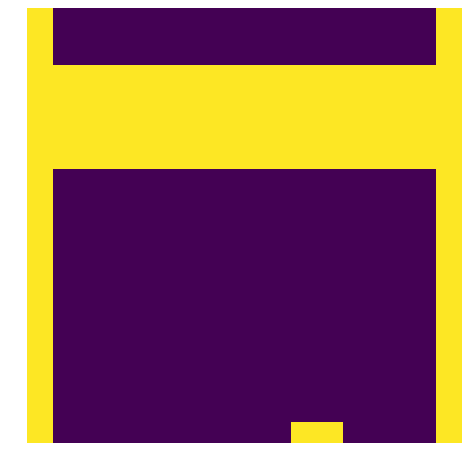

Welcome to AI Breakout!
Starting Game 1 of 20...
Total game score was: 2.0

Welcome to AI Breakout!
Starting Game 2 of 20...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 3 of 20...
Total game score was: 3.0

Welcome to AI Breakout!
Starting Game 4 of 20...
Total game score was: 4.0

Welcome to AI Breakout!
Starting Game 5 of 20...
Total game score was: 4.0

Welcome to AI Breakout!
Starting Game 6 of 20...
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 7 of 20...
Total game score was: 3.0

Welcome to AI Breakout!
Starting Game 8 of 20...


KeyboardInterrupt: 

In [23]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation = process_obs(observation)

plot_state(observation.reshape((84,84)))

episodes = 20
done = False
epsilon = 0


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    game = True
    obs = []
    while game:
        
        if (len(obs) == 0):
            action = 1
        elif (len(obs) > 1) and (np.array_equal(obs[-1],obs[-2])):
            action = 1
        else:
            rand = np.random.uniform(0,1)
            if  rand < epsilon:
                action = env.action_space.sample()
            else:
                observation = np.expand_dims(observation,0)
                action = np.argmax(mod.predict(observation))
            
        #print(action)
        observation, reward, done, info = env.step(action)
        observation = process_obs(observation)
        obs.append(observation)

        sum += reward
        time.sleep(0.05)
        env.render()

        if done:
            print("Total game score was: {}\n".format(sum))
            observation = env.reset()
            observation = process_obs(observation)
            game = False
env.close()        

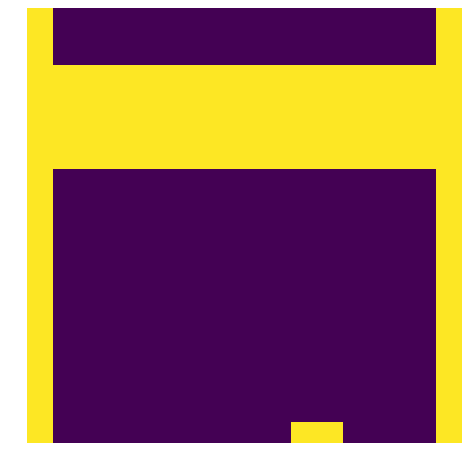

In [20]:
plot_state(observation.reshape((84,84)))

In [21]:
observation.shape

(84, 84, 1)